In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)

In [3]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [4]:
len(df)

325

In [5]:
df = df.dropna()

In [6]:
len(df)

325

<AxesSubplot:xlabel='DATE'>

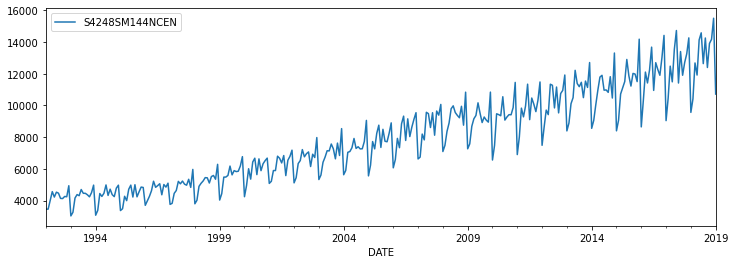

In [7]:
df.plot(figsize=(12,4))

In [8]:
y = df["S4248SM144NCEN"].values.astype(float)

In [9]:
test_size = 12

In [10]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [14]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [15]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [16]:
train_norm

array([[-0.92683135],
       [-0.92700231],
       [-0.83400291],
       [-0.73792632],
       [-0.79656381],
       [-0.74390974],
       [-0.75467989],
       [-0.81092401],
       [-0.81280451],
       [-0.79006753],
       [-0.79331567],
       [-0.67433114],
       [-1.        ],
       [-0.9606804 ],
       [-0.80699205],
       [-0.76989486],
       [-0.7818617 ],
       [-0.71536029],
       [-0.75604753],
       [-0.75621848],
       [-0.77211727],
       [-0.79399949],
       [-0.74886742],
       [-0.66783486],
       [-0.99247799],
       [-0.94084965],
       [-0.75861185],
       [-0.78972562],
       [-0.75570562],
       [-0.66595436],
       [-0.77895547],
       [-0.71142833],
       [-0.77040773],
       [-0.79194803],
       [-0.70031627],
       [-0.66834772],
       [-0.94204633],
       [-0.92255748],
       [-0.78835798],
       [-0.83537054],
       [-0.71211215],
       [-0.66783486],
       [-0.7962219 ],
       [-0.66339003],
       [-0.79417044],
       [-0

In [17]:
window_size = 12

len(y) - test_size - window_size

301

In [18]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [19]:
train_norm.shape

torch.Size([313])

In [20]:
window_size = 12

In [22]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
        
    return out

In [23]:
train_data = input_data(train_norm, window_size)

In [24]:
len(train_data)

301

In [25]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [26]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [27]:
torch.manual_seed(101)

model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [29]:
EPOCHS = 100

import time

start_time = time.time()


for epoch in range(EPOCHS):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1} Loss: {loss.item()}")

total_time = time.time() - start_time
print(f"Total time of training: {total_time*60} min")

Epoch: 1 Loss: 0.25310197472572327
Epoch: 2 Loss: 0.37531983852386475
Epoch: 3 Loss: 0.39027222990989685
Epoch: 4 Loss: 0.34934669733047485
Epoch: 5 Loss: 0.3308565020561218
Epoch: 6 Loss: 0.33229973912239075
Epoch: 7 Loss: 0.32670360803604126
Epoch: 8 Loss: 0.3207411766052246
Epoch: 9 Loss: 0.3065352737903595
Epoch: 10 Loss: 0.29518023133277893
Epoch: 11 Loss: 0.26934343576431274
Epoch: 12 Loss: 0.25998449325561523
Epoch: 13 Loss: 0.2466583251953125
Epoch: 14 Loss: 0.2240382879972458
Epoch: 15 Loss: 0.18602679669857025
Epoch: 16 Loss: 0.1856096386909485
Epoch: 17 Loss: 0.17209307849407196
Epoch: 18 Loss: 0.25161734223365784
Epoch: 19 Loss: 0.22557584941387177
Epoch: 20 Loss: 0.1744897961616516
Epoch: 21 Loss: 0.2023598700761795
Epoch: 22 Loss: 0.20818661153316498
Epoch: 23 Loss: 0.16646955907344818
Epoch: 24 Loss: 0.17595747113227844
Epoch: 25 Loss: 0.11982777714729309
Epoch: 26 Loss: 0.09494012594223022
Epoch: 27 Loss: 0.04482637718319893
Epoch: 28 Loss: 0.07156451791524887
Epoch: 29

In [33]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())
        

In [34]:
preds[window_size:]

[0.2612956762313843,
 0.6842846870422363,
 0.39159226417541504,
 0.8364370465278625,
 0.9861672520637512,
 0.3965175151824951,
 0.9746654629707336,
 0.4544048309326172,
 0.7777097821235657,
 0.640521764755249,
 0.6270933151245117,
 0.25483715534210205]

In [38]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [39]:
true_predictions

array([[10408.94905812],
       [12883.22327685],
       [11171.11894929],
       [13773.23850366],
       [14649.08534095],
       [11199.92920506],
       [14581.80562565],
       [11538.54105854],
       [13429.71337053],
       [12627.23206294],
       [12548.68234682],
       [10371.16994017]])

In [40]:
df["S4248SM144NCEN"][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [41]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')

In [42]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

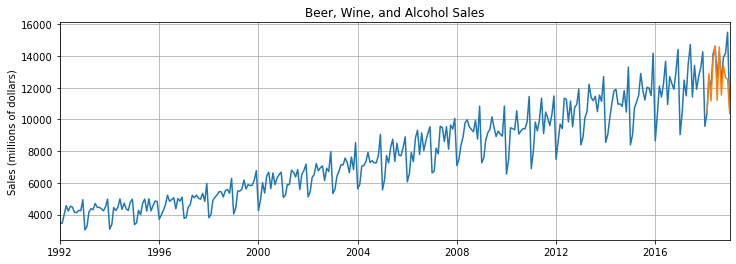

In [44]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

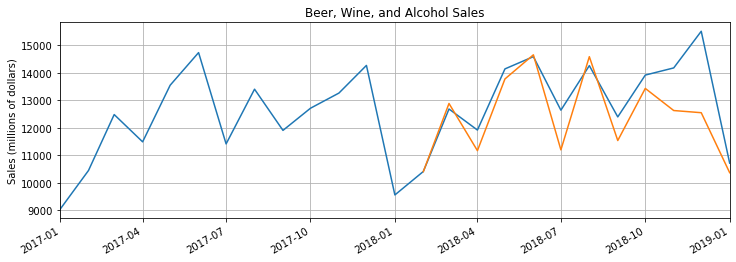

In [45]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [46]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02874834
Epoch:  2 Loss: 0.01326633
Epoch:  3 Loss: 0.02101872
Epoch:  4 Loss: 0.01747506
Epoch:  5 Loss: 0.01444324
Epoch:  6 Loss: 0.01360563
Epoch:  7 Loss: 0.01322775
Epoch:  8 Loss: 0.01300842
Epoch:  9 Loss: 0.01264114
Epoch: 10 Loss: 0.01200873
Epoch: 11 Loss: 0.01189025
Epoch: 12 Loss: 0.01123014
Epoch: 13 Loss: 0.01111034
Epoch: 14 Loss: 0.01137467
Epoch: 15 Loss: 0.01201900
Epoch: 16 Loss: 0.01432502
Epoch: 17 Loss: 0.01242777
Epoch: 18 Loss: 0.00900940
Epoch: 19 Loss: 0.00698038
Epoch: 20 Loss: 0.00557621
Epoch: 21 Loss: 0.00877142
Epoch: 22 Loss: 0.00646719
Epoch: 23 Loss: 0.00661006
Epoch: 24 Loss: 0.00340628
Epoch: 25 Loss: 0.00624019
Epoch: 26 Loss: 0.00509826
Epoch: 27 Loss: 0.00376026
Epoch: 28 Loss: 0.00120889
Epoch: 29 Loss: 0.00306584
Epoch: 30 Loss: 0.00033309
Epoch: 31 Loss: 0.00100618
Epoch: 32 Loss: 0.00488637
Epoch: 33 Loss: 0.00029106
Epoch: 34 Loss: 0.00079296
Epoch: 35 Loss: 0.00058969
Epoch: 36 Loss: 0.00010868
Epoch: 37 Loss: 0.00101659
E

In [47]:
window_size = 12
future = 12
L = len(seq)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

In [48]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

In [49]:
true_predictions

array([[10415.00001808],
       [12683.00013363],
       [11919.00006013],
       [14137.99993426],
       [14583.00009555],
       [12640.00017402],
       [14257.00005591],
       [12395.9999277 ],
       [13913.99994579],
       [14173.99995232],
       [15504.        ],
       [10717.99998423],
       [11397.46686992],
       [13250.74368095],
       [12532.7837148 ],
       [14547.36994323],
       [14709.36928105],
       [13725.78288835],
       [15037.70932558],
       [13293.10724846],
       [14963.54957089],
       [15171.71298614],
       [16006.96314186],
       [12042.41124898]])

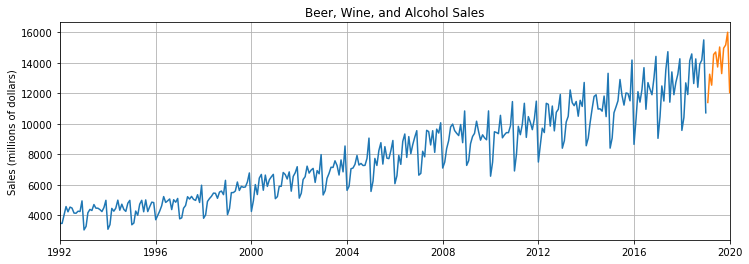

In [50]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()